https://www.quantconnect.com/terminal/processCache/?request=embedded_backtest_98cf554d6f396c80acc737ddc2e363a5.html is an example that implements all of the QuantConnect API in vanilla Python to demonstrate the JSON calls and responses.

 - For each Project Fetch 5Y, 2023 or YTD given this as argument

In [1]:
project_IDs = [19014068, 19015686, 19016182, 19016331, 19025603, 19025674, 19015442, ]
backtest_period = '5YR'

In [2]:
url_readBacktest        = f"https://www.quantconnect.com/api/v2/backtests/read"
url_readProject         = f"https://www.quantconnect.com/api/v2/projects/read"
url_listProjectBacktest = f"https://www.quantconnect.com/api/v2/backtests/list"

# Your QuantConnect API credentials
USER_ID = '92090'
API_TOKEN = '7df20f89e389d894c09528956e8bbd1c8a76946c12d56dd8624a6705825243ef'

In [3]:
import requests
import hashlib
import time
import base64
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# Function to create headers with appropriate authentication
def get_authenticated_headers():
    timestamp = str(int(time.time()))
    data_string = f"{API_TOKEN}:{timestamp}"
    hashed_token = hashlib.sha256(data_string.encode('utf-8')).hexdigest()
    auth_string = f"{USER_ID}:{hashed_token}"
    api_token = base64.b64encode(auth_string.encode('utf-8')).decode('ascii')
    return {
        'Authorization': f'Basic {api_token}',
        'Timestamp': timestamp
    }


### List Backtests by providing ProjectID

['backtestId', 'status', 'name', 'note', 'created', 'completed', 'progress', 'result', 'error', 'stacktrace', 'projectId', 'optimizationId', 'sparkline', 'sharpeRatio', 'alpha', 'beta', 'compoundingAnnualReturn', 'drawdown', 'lossRate', 'netProfit', 'parameters', 'psr', 'securityTypes', 'sortinoRatio', 'tradeableDates', 'trades', 'treynorRatio', 'winRate', 'outOfSampleMaxEndDate', 'outOfSampleDays', 'parameterSet', 'snapshotId', 'nodeName', 'tags'])

### Read Backtests 
- fetch_backtest_result(project_id, backtest_id, key = None)
https://www.quantconnect.com/docs/v2/cloud-platform/api-reference/backtest-management/read-backtest/backtest-statistics

['note', 'name', 'organizationId', 'projectId', 'completed', 'optimizationId', 'backtestId', 'tradeableDates', 'researchGuide', 'backtestStart', 'backtestEnd', 'created', 'snapshotId', 'status', 'error', 'stacktrace', 'progress', 'hasInitializeError', 'charts', 'parameterSet', 'rollingWindow', 'runtimeStatistics', 'statistics', 'totalPerformance', 'nodeName', 'outOfSampleMaxEndDate', 'outOfSampleDays'])

In [4]:
# https://www.quantconnect.com/docs/v2/cloud-platform/api-reference/backtest-management/list-backtests

def list_backtests(project_id):
    response = requests.post(url_listProjectBacktest, headers=get_authenticated_headers(), data={'projectId': project_id, 'includeStatistics': True})
    if response.status_code == 200:
        return response.json().get('backtests', [])
    else:
        print("Failed to list backtests:", response.status_code, response.text)
        return []


def fetch_project_details(project_id):
    headers = get_authenticated_headers()
    # Send the projectId in the request body as you do for backtests
    response = requests.post(url_readProject, headers=headers, data={'projectId': project_id})
    if response.status_code == 200:
        return response.json()['projects'][0]  # Assuming 'projects' contains the list of project details
    else:
        print("Failed to retrieve project details:", response.status_code, response.text)
        return None

# fetch_project_details(19014068)['name']

def fetch_backtest_result(project_id, backtest_id, key = None):
    response = requests.post(url_readBacktest, headers=get_authenticated_headers(), data={'projectId': project_id, 'backtestId': backtest_id})
    if response.status_code == 200:
        
        if key is not None:
            return response.json()['backtest'][key]
        else:
            return response.json()['backtest']
    else:
        print("Failed to retrieve backtest results:", response.status_code, response.text)
        return {}
    
# backtest_result = fetch_backtest_result(project_id=19016182, backtest_id='fe286f90bb0da4738404135abd17136d')



In [10]:

backtest_period = '5YR' # 'YTD', '2023'
# backtest_period = 


# Metrics from api/v2/backtests/list
strategy_dict = {ID: next((bkt for bkt in list_backtests(ID) if bkt['name'] == backtest_period), None) for ID in project_IDs }
backtest_metrics = ['alpha',  'beta', 'compoundingAnnualReturn', 'drawdown', 'lossRate', 'netProfit', 'parameters', 'psr', 'sortinoRatio', 'trades' ,'treynorRatio', 'winRate','backtestId'] 
df_metrics = pd.DataFrame({k: {m: v[m] for m in backtest_metrics if m in v} for k, v in strategy_dict.items()}).transpose()


strategy_dict       = {}
strategy_equity_dict = {}
strategy_return_dict = {}
strategy_trades_dict = {}

for projectID, row in df_metrics.iterrows():
    backtest_result = fetch_backtest_result(project_id=projectID, backtest_id=row['backtestId'], key=None)

    strategy_dict[projectID] = backtest_result # reusing this name as earlier sent to df_metrics
    
    # Creating DataFrame for equity curve
    equity_values = backtest_result['charts']['Strategy Equity']['series']['Equity']['values']
    equity_df = pd.DataFrame(equity_values, columns=['Timestamp', 'Open', 'High', 'Low', 'Close'])
    equity_df.index = pd.to_datetime(equity_df['Timestamp'], unit='s')
    equity_df.drop(columns=['Timestamp', 'Open', 'High', 'Low'], inplace=True)
    strategy_equity_dict[projectID] = equity_df
    
    # Creating DataFrame for returns curve
    return_values = backtest_result['charts']['Strategy Equity']['series']['Return']['values']
    return_df = pd.DataFrame(return_values, columns=['Timestamp', 'Return'])
    return_df.index = pd.to_datetime(return_df['Timestamp'], unit='s')
    return_df.drop(columns=['Timestamp'], inplace=True)
    strategy_return_dict[projectID] = return_df

    # Extracting trade data - contains data/metric for each trade Individually
    trades = backtest_result['totalPerformance']['closedTrades']
    trade_df = pd.DataFrame([{
        **{f'symbol_{k}': v for k, v in trade.get('symbol', {}).items()}, 
        **{k: v for k, v in trade.items() if k not in ['symbol', 'direction', 'symbol_value', 'symbol_id']}
    } for trade in trades])
    strategy_trades_dict[projectID] = trade_df


# This has all the Metrics from nested keys in strategy_dict (the one in the loop)
df = pd.DataFrame({
    ID: {
        **v['statistics'], 
        **v['totalPerformance']['tradeStatistics'],
        **v['totalPerformance']['portfolioStatistics'], 
        **v['runtimeStatistics']
    }
    for ID, v in strategy_dict.items()
}).transpose()  # Transpose to make each project ID a row


# For deciphering which column came from which source: - Not using
first_key = next(iter(strategy_dict))
metrics_Index = {
    'backtestList': list(df_metrics.columns),
    'statistics': list(strategy_dict[first_key]['statistics'].keys()),
    'tradeStatistics': list(strategy_dict[first_key]['totalPerformance']['tradeStatistics'].keys()),
    'portfolioStatistics': list(strategy_dict[first_key]['totalPerformance']['portfolioStatistics'].keys()),
    'runtimeStatistics': list(strategy_dict[first_key]['runtimeStatistics'].keys())
}

df.index.name = 'ProjectID'

final_df = pd.concat([df_metrics, df], axis=1)
final_df = final_df.T
project_names = {ID: fetch_project_details(ID)['name'] for ID in final_df.columns}
final_df.columns = [project_names.get(ID, ID) for ID in final_df.columns]

mask_first = final_df.index.isin(['winRate', 'lossRate', 'sortinoRatio', 'beta', 'alpha', 'treynorRatio']) & final_df.index.duplicated(keep='last')
mask_second = ~final_df.index.isin(['winRate', 'lossRate', 'sortinoRatio', 'beta', 'alpha', 'treynorRatio']) & final_df.index.duplicated(keep='first')
final_df = final_df[~(mask_first | mask_second)]

final_df

TypeError: argument of type 'NoneType' is not iterable

In [6]:
strategy_equity_dict[19016182].tail(2)

,Close
Timestamp,
2024-08-05 17:00:00,46719.7825
2024-08-06 04:00:00,46717.6019


In [13]:

strategy_equity_df = pd.concat({projectID: df['Close'] for projectID, df in strategy_equity_dict.items()},axis=1)
project_names = {ID: fetch_project_details(ID)['name'][3:] for ID in strategy_equity_df.columns}
strategy_equity_df.columns = [project_names.get(ID, ID) for ID in strategy_equity_df.columns]
strategy_equity_df.sort_index(inplace=True)
strategy_equity_df.ffill(inplace=True)
strategy_equity_df.tail(10)

,609IntradayReversalinUS,300OvernightMomentumStrategy,97HalfDayReversal,986OpeningRangeBreakoutStrategyinIndividualStocks,959VolumeWeightedAveragePriceasPreciseTrendFollowingIndicatorforDayTraders,317TradingFOMCAnnouncementswithSummaryofEconomicProjections,1016IntradayMomentumStrategyforSP500ETF
Timestamp,,,,,,,
2024-08-03 04:00:00,63416.2286,17162.6110,49840.0478,123362.0288,168641.7313,100505.9136,261566.4896
2024-08-04 04:00:00,63416.2286,17162.6110,49840.0478,123362.0288,168641.7313,100505.9136,261566.4896
2024-08-05 04:00:00,63416.2286,17162.6110,49840.0478,123362.0288,168641.7313,100505.9136,261566.4896
2024-08-05 13:31:00,63416.2286,23353.6373,49840.0478,123362.0288,168637.7713,100505.9136,261566.4896
2024-08-05 16:16:00,63416.2286,23353.6373,49840.0478,124061.6775,168637.7713,100505.9136,261566.4896
2024-08-05 17:00:00,63416.2286,23353.6373,46719.7825,124061.6775,168637.7713,100505.9136,261566.4896
2024-08-05 20:00:00,63416.2286,23353.6373,46719.7825,124061.6775,168637.7713,100505.9136,264855.9896
2024-08-06 04:00:00,63385.7286,18715.3331,46717.6019,124079.4610,171500.4513,100505.9136,264855.9896
2024-08-06 13:31:00,63385.7286,18715.3331,46717.6019,124079.4610,171496.5513,100505.9136,264855.9896


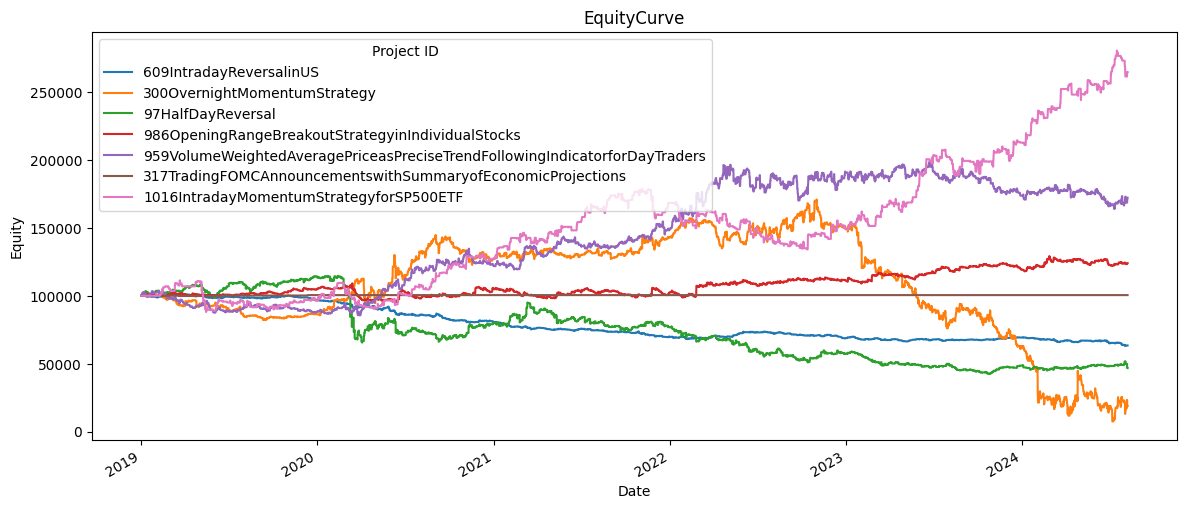

In [15]:
import matplotlib.pyplot as plt
strategy_equity_df.plot(figsize=(14, 6), title='EquityCurve').legend(title='Project ID')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.show()

In [9]:
stop

NameError: name 'stop' is not defined

In [ ]:
len(strategy_equity_df)

In [ ]:
len(strategy_equity_dict[19016182])

In [ ]:
strategy_equity_dict[19016182].tail(3)

# TODO

- see if whatall can be used

In [ ]:
strategy_return_dict[19016182].tail(2)

In [ ]:
strategy_trades_dict[19016182].head(2)

In [ ]:
strategy_dict[19016182].keys()

## Charts

- To get Benchmark, drawdown etc 

In [ ]:
backtest_result['charts']['Strategy Equity']['series'].keys()

In [ ]:
backtest_result['charts'].keys()

# backtest_result['charts']['Strategy Equity']['series']['Equity']['values']

## Rolling Window

In [ ]:
backtest_keys = ['name', 'projectId', 'backtestId', 'tradeableDates', 'backtestStart', 'backtestEnd', ]
aggregated_keys = {prefix: [key for key in backtest_result['rollingWindow'].keys() if key.startswith(prefix)] for prefix in ['M1_', 'M3_', 'M6_', 'M12_']}

for k in aggregated_keys.keys():
    print(k, ' :: ', len(aggregated_keys[k]))


### Each key in rollingWindow such as 'M1_20190131' has 3 sub keys:
backtest_result['rollingWindow']['M1_20190131']['portfolioStatistics'].keys()


    1. tradeStatistics
    2. portfolioStatistics
    3. closedTrades

1. tradeStatistics Keys: ['startDateTime', 'endDateTime', 'totalNumberOfTrades', 'numberOfWinningTrades', 'numberOfLosingTrades', 'totalProfitLoss', 'totalProfit', 'totalLoss', 'largestProfit', 'largestLoss', 'averageProfitLoss', 'averageProfit', 'averageLoss', 'averageTradeDuration', 'averageWinningTradeDuration', 'averageLosingTradeDuration', 'medianTradeDuration', 'medianWinningTradeDuration', 'medianLosingTradeDuration', 'maxConsecutiveWinningTrades', 'maxConsecutiveLosingTrades', 'profitLossRatio', 'winLossRatio', 'winRate', 'lossRate', 'averageMAE', 'averageMFE', 'largestMAE', 'largestMFE', 'maximumClosedTradeDrawdown', 'maximumIntraTradeDrawdown', 'profitLossStandardDeviation', 'profitLossDownsideDeviation', 'profitFactor', 'sharpeRatio', 'sortinoRatio', 'profitToMaxDrawdownRatio', 'maximumEndTradeDrawdown', 'averageEndTradeDrawdown', 'maximumDrawdownDuration', 'totalFees']


2. portfolioStatistics Keys : ['averageWinRate', 'averageLossRate', 'profitLossRatio', 'winRate', 'lossRate', 'expectancy', 'startEquity', 'endEquity', 'compoundingAnnualReturn', 'drawdown', 'totalNetProfit', 'sharpeRatio', 'probabilisticSharpeRatio', 'sortinoRatio', 'alpha', 'beta', 'annualStandardDeviation', 'annualVariance', 'informationRatio', 'trackingError', 'treynorRatio', 'portfolioTurnover', 'valueAtRisk99', 'valueAtRisk95']

3. Issue is getting empty closedTrades for all rollingWindow keys such as backtest_result['rollingWindow']['M1_20190131']['closedTrades']


In [ ]:
# merges all values of tradeStatistics and portfolioStatistics with each key as a row (eg. 'M1_20190131') in backtest_result['rollingWindow']

data = []
for key, value in backtest_result['rollingWindow'].items():
    row = {'Date': key, **value['tradeStatistics'], **value['portfolioStatistics']}
    data.append(row)

df = pd.DataFrame(data)
df.head()

In [ ]:
backtest_result['totalPerformance']['portfolioStatistics']